In [1]:
import pandas as pd
import sqlite3 
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
import seaborn as sns
import sklearn.metrics as metrics
import statsmodels.api as sm
from lin_reg import best_line
%matplotlib inline

ModuleNotFoundError: No module named 'lin_reg'

In [2]:
# Reading in data files

movie_budgets = pd.read_csv('../data/tn.movie_budgets.csv.gz')
tmdb_movies = pd.read_csv('../data/tmdb.movies.csv.gz')
rt_reviews = pd.read_csv('../data/rt.reviews.tsv.gz', sep = '\t', encoding='latin-1')
rt_movie_info = pd.read_csv('../data/rt.movie_info.tsv.gz', sep = '\t')
movie_gross = pd.read_csv('../data/bom.movie_gross.csv.gz')

con = sqlite3.connect('../data/im.db')
schema_imdb = pd.read_sql(
"""
SELECT *
FROM sqlite_master;
""", con)
schema_imdb

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


## Looking at imdb

In [3]:
directors_experienced = pd.read_sql(
"""
SELECT DISTINCT person_id
FROM directors
GROUP BY person_id
HAVING COUNT() >5;
""", con)
directors_experienced

,person_id
0,nm0000095
1,nm0000108
2,nm0000110
3,nm0000116
4,nm0000123
...,...
9737,nm9983975
9738,nm9985563
9739,nm9986248
9740,nm9987882


In [4]:
directors_not_experienced = pd.read_sql(
"""
SELECT DISTINCT person_id
FROM directors
GROUP BY person_id
HAVING COUNT() <=5;
""", con)
directors_not_experienced

,person_id
0,nm0000080
1,nm0000118
2,nm0000127
3,nm0000128
4,nm0000136
...,...
99506,nm9993281
99507,nm9993379
99508,nm9993380
99509,nm9993381


In [5]:
writers = pd.read_sql(
"""
SELECT DISTINCT person_id
FROM writers
GROUP BY person_id
HAVING COUNT() >5;
""", con)
writers

,person_id
0,nm0000095
1,nm0000108
2,nm0000116
3,nm0000118
4,nm0000175
...,...
5906,nm9977220
5907,nm9983975
5908,nm9985563
5909,nm9987882


In [6]:
known_for = pd.read_sql(
"""
SELECT *
FROM known_for
""", con)
known_for

,person_id,movie_id
0,nm0061671,tt0837562
1,nm0061671,tt2398241
2,nm0061671,tt0844471
3,nm0061671,tt0118553
4,nm0061865,tt0896534
...,...,...
1638255,nm9990690,tt9090932
1638256,nm9990690,tt8737130
1638257,nm9991320,tt8734436
1638258,nm9991320,tt9615610


In [7]:
movie_ratings = pd.read_sql(
"""
SELECT *
FROM movie_ratings
""", con)
movie_ratings

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21
...,...,...,...
73851,tt9805820,8.1,25
73852,tt9844256,7.5,24
73853,tt9851050,4.7,14
73854,tt9886934,7.0,5


In [8]:
movie_akas = pd.read_sql(
"""
SELECT *
FROM movie_akas
""", con)
movie_akas

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title,0.0
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None,0.0
...,...,...,...,...,...,...,...,...
331698,tt9827784,2,Sayonara kuchibiru,None,None,original,None,1.0
331699,tt9827784,3,Farewell Song,XWW,en,imdbDisplay,None,0.0
331700,tt9880178,1,La atención,None,None,original,None,1.0
331701,tt9880178,2,La atención,ES,None,None,None,0.0


In [9]:
movie_basics = pd.read_sql(
"""
SELECT *
FROM movie_basics
""", con)
movie_basics

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,None


In [10]:
principals = pd.read_sql(
"""
SELECT *
FROM principals
WHERE category = 'actor' OR category = 'actress' OR characters != 'None'
GROUP BY person_id
HAVING COUNT() >5
""", con)
principals

,movie_id,ordering,person_id,category,job,characters
0,tt1637702,3,nm0000026,archive_footage,None,"[""Himself""]"
1,tt1979172,2,nm0000092,actor,None,"[""John Cleese"",""Exploding Don"",""David Frost""]"
2,tt1001526,3,nm0000093,actor,None,"[""Metro Man""]"
3,tt1849742,3,nm0000095,self,None,"[""Himself""]"
4,tt1770734,3,nm0000096,actress,None,"[""Kate Fletcher""]"
...,...,...,...,...,...,...
8938,tt2284964,1,nm9575332,actor,None,None
8939,tt4898004,1,nm9706424,actor,None,None
8940,tt8310586,3,nm9779533,actor,None,None
8941,tt10457158,4,nm9799185,actor,None,"[""Kondo""]"


In [11]:
persons = pd.read_sql(
"""
SELECT *
FROM persons
""", con)
persons

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"
...,...,...,...,...,...
606643,nm9990381,Susan Grobes,NaN,NaN,actress
606644,nm9990690,Joo Yeon So,NaN,NaN,actress
606645,nm9991320,Madeline Smith,NaN,NaN,actress
606646,nm9991786,Michelle Modigliani,NaN,NaN,producer


## Testing experienced vs. not experienced Directors and Writers

In [12]:
d_n_e = pd.read_sql(
"""
SELECT m.averagerating, person_id
FROM movie_ratings as m
    JOIN (SELECT DISTINCT movie_id, person_id
FROM directors
GROUP BY person_id
HAVING COUNT() <=5) as d_e
    ON d_e.movie_id = m.movie_id
""", con)
d_n_e.describe(include='all')

,averagerating,person_id
count,45250.000000,45250
unique,NaN,45250
top,NaN,nm6385383
freq,NaN,1
mean,6.480986,NaN
std,1.488203,NaN
min,1.000000,NaN
25%,5.600000,NaN
50%,6.600000,NaN
75%,7.500000,NaN


In [13]:
d_e = pd.read_sql(
"""
SELECT m.averagerating, person_id
FROM movie_ratings as m
    JOIN (SELECT DISTINCT movie_id, person_id
FROM directors
GROUP BY person_id
HAVING COUNT() >5) as d_n_e
    ON d_n_e.movie_id = m.movie_id
""", con)
d_e.describe(include='all')

,averagerating,person_id
count,7081.000000,7081
unique,NaN,7081
top,NaN,nm0644352
freq,NaN,1
mean,6.096639,NaN
std,1.341364,NaN
min,1.000000,NaN
25%,5.300000,NaN
50%,6.200000,NaN
75%,7.000000,NaN


In [14]:
w_n_e = pd.read_sql(
"""
SELECT m.averagerating, person_id
FROM movie_ratings as m
    JOIN (SELECT DISTINCT movie_id, person_id
FROM writers
GROUP BY person_id
HAVING COUNT() <=5) as w_n_e
    ON w_n_e.movie_id = m.movie_id
""", con)
w_n_e.describe(include='all')

,averagerating,person_id
count,67670.000000,67670
unique,NaN,67670
top,NaN,nm5588413
freq,NaN,1
mean,6.268011,NaN
std,1.448802,NaN
min,1.000000,NaN
25%,5.400000,NaN
50%,6.400000,NaN
75%,7.300000,NaN


In [15]:
w_e = pd.read_sql(
"""
SELECT m.averagerating, person_id
FROM movie_ratings as m
    JOIN (SELECT DISTINCT movie_id, person_id
FROM writers
GROUP BY person_id
HAVING COUNT() >5) as w_e
    ON w_e.movie_id = m.movie_id
""", con)
w_e.describe(include='all')

,averagerating,person_id
count,4383.000000,4383
unique,NaN,4383
top,NaN,nm7553098
freq,NaN,1
mean,6.041273,NaN
std,1.344070,NaN
min,1.000000,NaN
25%,5.200000,NaN
50%,6.100000,NaN
75%,7.000000,NaN


## Testing Runtime

In [16]:
movie_budgets.rename(columns={"movie":"primary_title"}, inplace=True)

In [17]:
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   primary_title      5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [46]:
movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [47]:
movie_basics_budget = pd.merge(movie_budgets, movie_basics, how ='inner', on='primary_title')

In [48]:
movie_basics_budget.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3815 entries, 0 to 3814
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 3815 non-null   int64  
 1   release_date       3815 non-null   object 
 2   primary_title      3815 non-null   object 
 3   production_budget  3815 non-null   object 
 4   domestic_gross     3815 non-null   object 
 5   worldwide_gross    3815 non-null   object 
 6   movie_id           3815 non-null   object 
 7   original_title     3814 non-null   object 
 8   start_year         3815 non-null   int64  
 9   runtime_minutes    3328 non-null   float64
 10  genres             3743 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 357.7+ KB


In [52]:
movie_basics_budget['runtime_minutes'].head()

0     93.0
1    136.0
2    113.0
3    141.0
4    149.0
Name: runtime_minutes, dtype: float64

In [62]:
movie_basics_budget['runtime_minutes'] = movie_basics_budget.dropna(subset = ['runtime_minutes'])

movie_basics_budget['production_budget'] = movie_basics_budget['production_budget'].str.replace('$','')
movie_basics_budget['production_budget'] = movie_basics_budget['production_budget'].str.replace(',','')
movie_basics_budget['worldwide_gross'] = movie_basics_budget['worldwide_gross'].str.replace('$','')
movie_basics_budget['worldwide_gross'] = movie_basics_budget['worldwide_gross'].str.replace(',','')


In [83]:
movie_basics_budget = movie_basics_budget[movie_basics_budget['domestic_gross'] != 0].copy()

In [84]:
x = movie_basics_budget['runtime_minutes']
x1 = movie_basics_budget['production_budget'].values.astype(int)
y = movie_basics_budget['worldwide_gross'].values.astype(int)

result = stats.ttest_ind(x1, y, equal_var=False)
result

Ttest_indResult(statistic=-18.486981835509745, pvalue=4.694595299268018e-73)

In [85]:
x = movie_basics_budget['runtime_minutes']
x1 = movie_basics_budget['production_budget'].values.astype(int)
y = movie_basics_budget['worldwide_gross'].values.astype(int)

result = stats.ttest_ind(x, y, equal_var=False)
result

Ttest_indResult(statistic=-28.800317055062386, pvalue=4.772461595352262e-163)

<AxesSubplot:xlabel='runtime_minutes'>

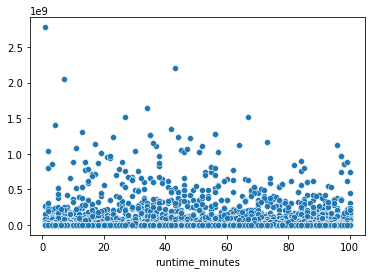

In [86]:
sns.scatterplot(x=x, y=y)

In [87]:
movie_basics_budget.dropna(subset = ['runtime_minutes'], inplace=True)
movie_basics_budget.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3328 entries, 0 to 3814
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 3328 non-null   int64 
 1   release_date       3328 non-null   object
 2   primary_title      3328 non-null   object
 3   production_budget  3328 non-null   object
 4   domestic_gross     3328 non-null   object
 5   worldwide_gross    3328 non-null   object
 6   movie_id           3328 non-null   object
 7   original_title     3328 non-null   object
 8   start_year         3328 non-null   int64 
 9   runtime_minutes    3328 non-null   object
 10  genres             3309 non-null   object
dtypes: int64(2), object(9)
memory usage: 312.0+ KB


In [88]:
x = sm.add_constant(movie_basics_budget['runtime_minutes'].values.astype(int))
x1 = sm.add_constant(movie_basics_budget['production_budget'].values.astype(int))
y = movie_basics_budget['worldwide_gross'].values.astype(int)

In [76]:
lin_reg_model = sm.OLS(y, x1).fit().summary()
lin_reg_model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     4990.
Date:                Mon, 04 Dec 2023   Prob (F-statistic):               0.00
Time:                        16:42:40   Log-Likelihood:                -66742.
No. Observations:                3328   AIC:                         1.335e+05
Df Residuals:                    3326   BIC:                         1.335e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.144e+07   2.65e+06     -4.318      0.000   -1.66e+07   -6.24e+06
x1             3.2805      0.046     70.643      0.000       3.189       3.372
==============================================================================
Omnibus:                     2337.757   Durbin-Watson:                   1.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            97115.258
Skew:                           2.828   Prob(JB):                         0.00
Kurtosis:                      28.852   Cond. No.                     7.03e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.03e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
lin_reg_model_2 = sm.OLS(y, x).fit().summary()


In [35]:
movie_gross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


## Looking at movie_budgets

In [79]:
zero_gross = movie_budgets.loc[movie_budgets['domestic_gross'] == 0]
zero_gross

,id,release_date,primary_title,production_budget,domestic_gross,worldwide_gross


In [ ]:
movie_budgets.head()

In [ ]:
movie_budgets.rename(columns={"movie":"primary_title"})

In [ ]:
movie_budgets.info()

In [ ]:
movie_budgets.describe(include='all')

## Looking at tmdb_movies

In [ ]:
tmdb_movies.head()

In [ ]:
tmdb_movies.info()

In [ ]:
tmdb_movies.describe(include='all')

## Looking at rt_reviews

In [ ]:
rt_reviews.head()

In [89]:
rt_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54123 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


In [90]:
rt_reviews.describe(include='all')

,id,review,rating,fresh,critic,top_critic,publisher,date
count,54432.000000,48869,40915,54432,51710,54432.000000,54123,54432
unique,NaN,48682,186,2,3496,NaN,1281,5963
top,NaN,Parental Content Review,3/5,fresh,Emanuel Levy,NaN,eFilmCritic.com,"January 1, 2000"
freq,NaN,24,4327,33035,595,NaN,673,4303
mean,1045.706882,NaN,NaN,NaN,NaN,0.240594,NaN,NaN
std,586.657046,NaN,NaN,NaN,NaN,0.427448,NaN,NaN
min,3.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,542.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
50%,1083.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
75%,1541.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN


## Looking at rt_movie_info

In [ ]:
rt_movie_info.head()

In [ ]:
rt_movie_info.info()

In [ ]:
rt_movie_info.describe(include='all')

## Looking at movie_gross

In [37]:
movie_gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [36]:
movie_gross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [ ]:
movie_gross.describe(include='all')

In [45]:
groupby = movie_gross.groupby('studio').mean()
groupby.sort_values('domestic_gross', ascending=False)

,domestic_gross,year
studio,,
BV,1.737644e+08,2013.688679
P/DW,1.682900e+08,2010.900000
WB (NL),8.879333e+07,2014.311111
Uni.,8.777138e+07,2014.163265
WB,8.691461e+07,2013.864286
...,...,...
Shout!,2.800000e+03,2014.000000
Synergetic,2.400000e+03,2018.000000
DR,8.000000e+02,2014.000000


In [ ]:
lin_reg_model_3 = sm.OLS(y, x1).fit().summary()
